In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.utils import resample

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
df = pd.read_csv('/kaggle/input/ecommerce-text-classification/ecommerceDataset.csv', header=None)
df.columns = ['Label', 'Text']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50425 entries, 0 to 50424
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   50425 non-null  object
 1   Text    50424 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB


In [ ]:
df.dropna()

,Label,Text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...
...,...,...
50420,Electronics,Strontium MicroSD Class 10 8GB Memory Card (Bl...
50421,Electronics,CrossBeats Wave Waterproof Bluetooth Wireless ...
50422,Electronics,Karbonn Titanium Wind W4 (White) Karbonn Titan...
50423,Electronics,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou..."


In [ ]:
df['Label'].value_counts()

Label
Household                 19313
Books                     11820
Electronics               10621
Clothing & Accessories     8671
Name: count, dtype: int64

# Preprocessing

In [ ]:
#drop duplicates
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27803 entries, 0 to 50410
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   27803 non-null  object
 1   Text    27802 non-null  object
dtypes: object(2)
memory usage: 651.6+ KB


In [ ]:
#mapping
mapping = {
    'Household': 0,
    'Books': 1,
    'Electronics': 2,
    'Clothing & Accessories' : 3
}

df['Label encoded'] = df['Label'].map(mapping)
df.head()

,Label,Text,Label encoded
0,Household,Paper Plane Design Framed Wall Hanging Motivat...,0
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",0
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,0
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1...",0
4,Household,Incredible Gifts India Wooden Happy Birthday U...,0


In [ ]:
#resample
household_entries = df[(df['Label'] == 'Household')]
books_entries = df[(df['Label'] == 'Books')]
electronic_entries = df[(df['Label'] == 'Electronics')]
cloth_acc_entries = df[(df['Label'] == 'Clothing & Accessories')]

entries_list = [household_entries, books_entries, electronic_entries, cloth_acc_entries]

resampled_entries_list = []
num_samples= 5000

for item in entries_list:
    resampled_entries = resample(item, replace=True, n_samples= num_samples, random_state= 42)
    resampled_entries_list.append(resampled_entries)

df = pd.concat(resampled_entries_list)

In [ ]:
df['Text'] = df['Text'].astype(str)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 12559 to 36711
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Label          20000 non-null  object
 1   Text           20000 non-null  object
 2   Label encoded  20000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 625.0+ KB


In [ ]:
df['Label'].value_counts()

Label
Household                 5000
Books                     5000
Electronics               5000
Clothing & Accessories    5000
Name: count, dtype: int64

In [ ]:
#train test split
x_train, x_temp, y_train, y_temp = train_test_split(df['Text'], df['Label encoded'], test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Model

In [ ]:
from transformers import AutoTokenizer
#tokenize
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-small')

max_length = 128
train_encoded = tokenizer(list(x_train), truncation=True, padding=True, max_length=max_length)
val_encoded = tokenizer(list(x_val), truncation=True, padding=True, max_length=max_length)
test_encoded = tokenizer(list(x_test), truncation=True, padding=True, max_length=max_length)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:558: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
import torch
#initialize dataset

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encoded, y_train.tolist())
val_dataset = CustomDataset(val_encoded, y_val.tolist())
test_dataset = CustomDataset(test_encoded, y_test.tolist())

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    logging_dir='./logs',
    report_to='tensorboard',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=1000,
)

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
    }

In [ ]:
from transformers import Trainer, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('microsoft/deberta-v3-small', num_labels=4)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_results = trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.310500,0.212010,0.952000
2,0.147000,0.199826,0.956500
3,0.097200,0.200097,0.963500


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

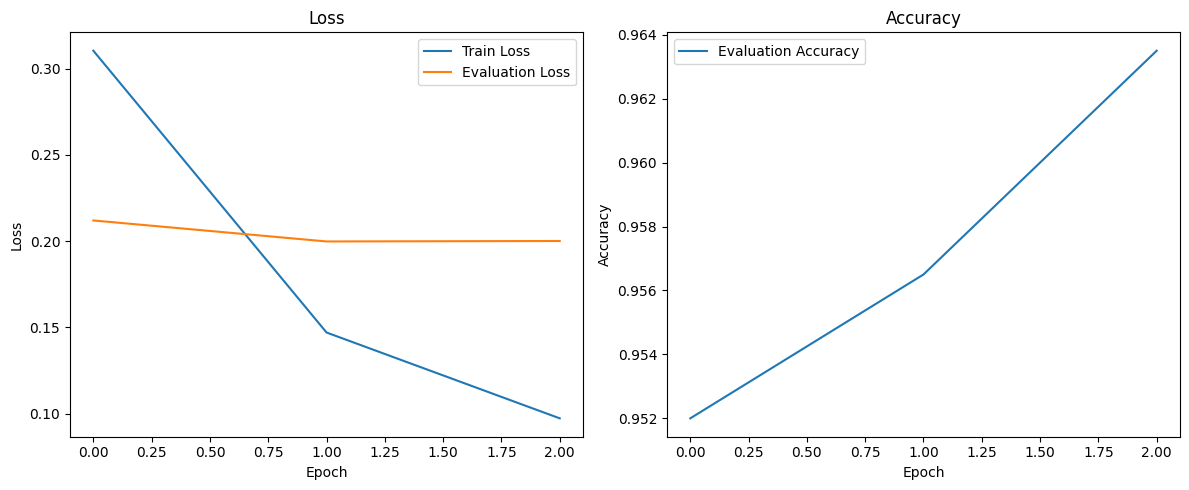

In [ ]:
logs = trainer.state.log_history

train_loss = [log['loss'] for log in logs if 'loss' in log]
eval_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]
eval_accuracy = [log['eval_accuracy'] for log in logs if 'eval_accuracy' in log]

plt.figure(figsize=(12, 5))

#loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(eval_loss, label='Evaluation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#acc
plt.subplot(1, 2, 2)
plt.plot(eval_accuracy, label='Evaluation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

#predict and report
predictions = trainer.predict(val_dataset)
preds = predictions.predictions.argmax(-1)
print(classification_report(y_val, preds, target_names=['Household', 'Books', 'Electronics', 'Clothing & Accessories']))

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


                        precision    recall  f1-score   support

             Household       0.95      0.95      0.95       506
                 Books       0.97      0.95      0.96       533
           Electronics       0.96      0.97      0.96       494
Clothing & Accessories       0.97      0.99      0.98       467

              accuracy                           0.96      2000
             macro avg       0.96      0.96      0.96      2000
          weighted avg       0.96      0.96      0.96      2000

